# Spatial coordinates, pandas compatibility and visualization

In [2]:
import numpy as np
np.set_printoptions(precision=3)

import sys
sys.path.append('../')

import pybvh
import matplotlib.pyplot as plt
from pathlib import Path

bvh_folder = Path('../bvh_data')

# Working with spatial coordinates

## Obtaining spatial coordinates

A lot of machine learning models studying skeleton movement recogition work with the joints position being given by spatial coordinates. Furthermore, frameworks to estimate human skeleton from video (OpenPose, AlphaPose etc.) return 3D spatial coordinates for the estimations of the skeleton joints positions. It is also easier to plot a 3D skeleton with plotting libraries (such as mathplotlab) with 3d coordinates. For all those reasons, it would be very handy to be able to easily get the 3D spatial coordinates of our joints in every frames.

We can obtain a raw numpy array containing the spatial coordinates using the bvh class method `get_spatial_coord()`. The which joints name corresponds to which column index can be found in `bvh.name2idx`.

In [16]:
filepath = bvh_folder / 'bvh_test1.bvh'
bvh = pybvh.read_bvh_file(filepath)

print(bvh)

24 elements in the Hierarchy, 56 frames at a frequency of 0.033333Hz


In [46]:
spatial_coord = bvh.get_spatial_coord()
print('The shape of the spatial coordinates numpy array is', spatial_coord.shape)

print(f"Spatial coordinates of 'Hips' on the first frame:      {spatial_coord[0, bvh.name2idx["Hips"], :]}")
print(f"Spatial coordinates of 'LeftHand' on the first frame:  {spatial_coord[0, bvh.name2idx["LeftHand"], :]}")


The shape of the spatial coordinates numpy array is (56, 29, 3)
Spatial coordinates of 'Hips' on the first frame:      [ 9.527 -0.75  36.277]
Spatial coordinates of 'LeftHand' on the first frame:  [  3.527 -25.877  53.989]


By looking at the shape of the array, you may have noticed that it has more columns than what we obtained with the euler angles. Indeed, here we have also the spatial position of the End sites nodes, which were missing in the rotational data.

`get_spatial_coord()` takes to 2 optional arguments: `frame_num` and `centered`. By giving a positive integer as a parameter to `frame_num`, we can force the function to only return the spatial coordinates of the frame indexed by this parameter. By default, `get_spatial_coord()` return the whole bvh sequences with joints as spatial coordinates. 

In [37]:
spatial_frame = bvh.get_spatial_coord(frame_num=5)
spatial_frame.shape

(29, 3)

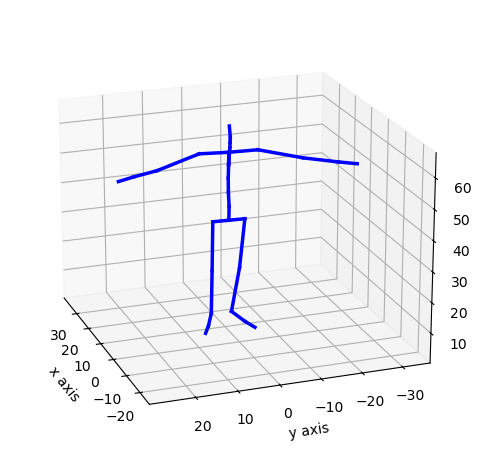

In [39]:
fig, ax = pybvh.plot.plot_frame(bvh, spatial_frame)
plt.show()

## Centering the data

The first 3 columns of the spatial coordinates array represent the root coordinates. By default, the method `get_spatial_coord()` returns *world coordinates*. World coordinates are the position of the root and joints as recorded in the bvh file. This behavior is directed by the `centered` argument, which has three possible modes.
- `centered = "world"`: default behavior, the skeleton is in the location strictly as described in the bvh file.
- `centered = "first"`: the data is centered such as the the first frame root position is considered to be [0, 0, 0]. From there, the skeleton moves in the space normally.
- `centered = "skeleton"`:  the coordinates are local to the skeleton (meaning the root coordinates are considered to be [0, 0, 0] in ALL frames).

Example of centering the data on the first frame. Notice how the coordinates of the root are 0, 0, 0, but only for the first frame.

In [54]:
centered_first_spatial_coord = bvh.get_spatial_coord(centered="first")
print("Coordinates of the root and Spine1 joints for the first 5 frames in 'first frame' centering:")
centered_first_spatial_coord[:5, 0:2, :]

Coordinates of the root and Spine1 joints for the first 5 frames in 'first frame' centering:


array([[[ 0.000e+00,  0.000e+00,  0.000e+00],
        [ 4.753e-02, -8.464e-02,  4.452e+00]],

       [[-4.580e-02, -1.000e-03, -2.800e-03],
        [ 1.573e-03, -8.614e-02,  4.449e+00]],

       [[-9.580e-02, -2.000e-03, -5.900e-03],
        [-4.842e-02, -8.778e-02,  4.446e+00]],

       [[-1.450e-01, -2.100e-03, -9.400e-03],
        [-9.862e-02, -8.862e-02,  4.442e+00]],

       [[-1.998e-01, -8.500e-03, -1.340e-02],
        [-1.526e-01, -9.492e-02,  4.438e+00]]])

We can also plot the same frame as previously, and notice that the coordinates have changed so that the root is close to the origin this time.

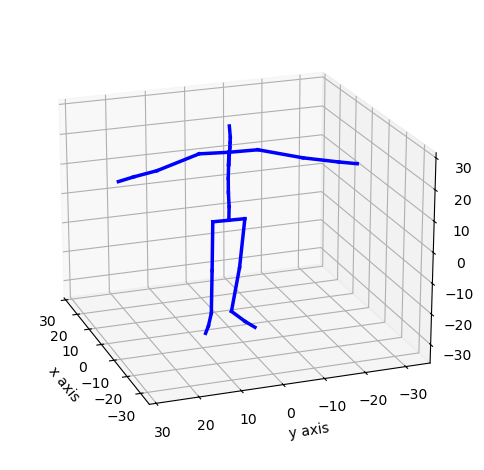

In [48]:
fig, ax = pybvh.plot.plot_frame(bvh, centered_first_spatial_coord[5])
plt.show()

Example of centering the data on the skeleton itself. Notice how the coordinates of the root are 0, 0, 0 for all the frames.

In [55]:
centered_skel_spatial_coord = bvh.get_spatial_coord(centered="skeleton")
print("Coordinates of the root and Spine1 joints for the first 5 frames in 'skeleton' centering:")

centered_skel_spatial_coord[:5, 0:2, :]

Coordinates of the root and Spine1 joints for the first 5 frames in 'skeleton' centering:


array([[[ 0.   ,  0.   ,  0.   ],
        [ 0.048, -0.085,  4.452]],

       [[ 0.   ,  0.   ,  0.   ],
        [ 0.047, -0.085,  4.452]],

       [[ 0.   ,  0.   ,  0.   ],
        [ 0.047, -0.086,  4.452]],

       [[ 0.   ,  0.   ,  0.   ],
        [ 0.046, -0.087,  4.452]],

       [[ 0.   ,  0.   ,  0.   ],
        [ 0.047, -0.086,  4.452]]])

## Pandas Dataframes with spatial coordinates

In [56]:
import pandas as pd

Though numpy array are perfect for quick computation, they are not very explicit. To make more sense of those spatial coordinates, we can once more use pandas. The method `get_df_constructor()` has a parameter `mode`, which accept 2 possibilities:
- `mode='euler'` (by default): returns a Dataframe constructor with the euler angles as data, 
- `mode='coordinates'`: returns a Dataframe constructor with the spatial coordinates as data. In this mode, we can also precise how we want to center the coordinates.

In [58]:
df_coord = pd.DataFrame(bvh.get_df_constructor(mode='coordinates', centered='first'))
df_coord.head()

,time,Hips_X,Hips_Y,Hips_Z,Spine_X,Spine_Y,Spine_Z,Spine1_X,Spine1_Y,Spine1_Z,...,LeftLeg_Z,LeftFoot_X,LeftFoot_Y,LeftFoot_Z,LeftToeBase_X,LeftToeBase_Y,LeftToeBase_Z,End Site LeftToeBase_X,End Site LeftToeBase_Y,End Site LeftToeBase_Z
0,0.000000,0.0000,0.0000,0.0000,0.047527,-0.084642,4.451772,0.835485,-0.204464,8.832691,...,-16.625785,2.528696,-1.626123,-32.353930,-1.814848,-3.511760,-33.946539,-4.907681,-4.861664,-34.608022
1,0.033333,-0.0458,-0.0010,-0.0028,0.001573,-0.086142,4.448964,0.791559,-0.205374,8.829534,...,-16.628189,2.528168,-1.626181,-32.353203,-1.815141,-3.511740,-33.946543,-4.907867,-4.861521,-34.608776
2,0.066667,-0.0958,-0.0020,-0.0059,-0.048418,-0.087781,4.445852,0.744598,-0.206567,8.825886,...,-16.630855,2.527316,-1.626564,-32.352585,-1.815855,-3.512307,-33.946086,-4.908391,-4.862205,-34.608964
3,0.100000,-0.1450,-0.0021,-0.0094,-0.098618,-0.088621,4.442348,0.696294,-0.207246,8.822043,...,-16.634356,2.526102,-1.626489,-32.351841,-1.816360,-3.512412,-33.947061,-4.908629,-4.862481,-34.610839
4,0.133333,-0.1998,-0.0085,-0.0134,-0.152634,-0.094917,4.438342,0.645839,-0.211599,8.817441,...,-16.636725,2.525258,-1.627009,-32.350633,-1.816885,-3.512833,-33.946837,-4.908618,-4.862758,-34.613397


# Changing the bones' size

## Copying the nodes offset from another bvh object

In some case we may want to use different offset than the one recorded in the bvh file. For example, if we want to normalize the spatial coordinates data by using a common skeleton for different bvh files. A simple way is to copy the offsets of a **similar skeleton** from another bvh object. Here similar skeleton means same hierarchy (same nodes, same parent-child relationships). To do so, we can use the `change_skeleton()` method of a bvh_object. This method takes as parameter another bvh object.

some nodes's offset from the original skeleton:
Hips's offset: [0. 0. 0.]
Spine's offset: [0.    0.    4.453]
Spine1's offset: [ 0.    -0.773  4.385]
Spine2's offset: [ 0.    -0.388  4.436]


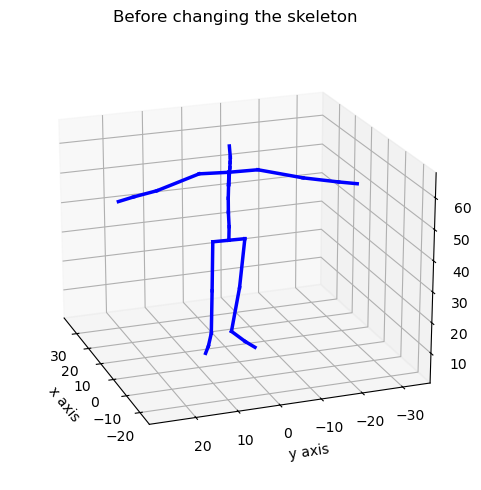

In [59]:
filepath = bvh_folder / 'bvh_test1.bvh'
bvh = pybvh.read_bvh_file(filepath)

print("some nodes's offset from the original skeleton:")
for i in range(4):
    print(f"{bvh.nodes[i].name}'s offset: {bvh.nodes[i].offset}")


fig, ax = pybvh.plot.plot_frame(bvh, bvh.get_spatial_coord(frame_num=5))
ax.set_title('Before changing the skeleton')
plt.show()

In [60]:
other_skeleton_filepath = bvh_folder / 'standard_skeleton.bvh'
bvh_different_skeleton = pybvh.read_bvh_file(other_skeleton_filepath)

print("\nnodes offset from the second bvh object that we want to copy:")
for i in range(4):
    print(f"{bvh_different_skeleton.nodes[i].name}'s offset: {bvh_different_skeleton.nodes[i].offset}")


nodes offset from the second bvh object that we want to copy:
Hips's offset: [0. 0. 0.]
Spine's offset: [ 0.   -0.38  4.  ]
Spine1's offset: [ 0.   -0.69  3.9 ]
Spine2's offset: [ 0.   -0.35  3.94]



nodes offset of the original skeleton after copying:
Hips's offset: [0. 0. 0.]
Spine's offset: [ 0.   -0.38  4.  ]
Spine1's offset: [ 0.   -0.69  3.9 ]
Spine2's offset: [ 0.   -0.35  3.94]


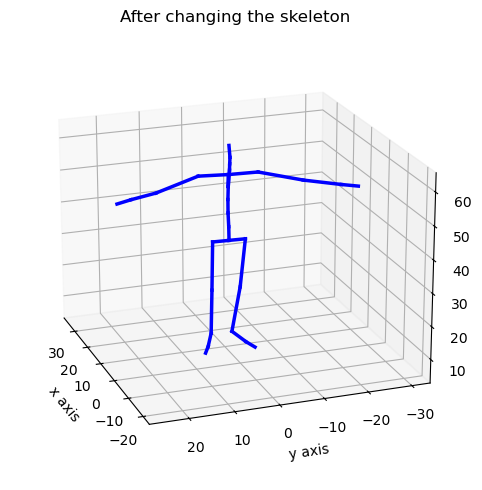

In [61]:
changed_skeleton = bvh.change_skeleton(bvh_different_skeleton)

print("\nnodes offset of the original skeleton after copying:")
for i in range(4):
    print(f"{changed_skeleton.nodes[i].name}'s offset: {changed_skeleton.nodes[i].offset}")


fig, ax = pybvh.plot.plot_frame(changed_skeleton, changed_skeleton.get_spatial_coord(frame_num=5))
ax.set_title('After changing the skeleton')
plt.show()

Because the skeletons between the 2 files are very close from each other, it is difficult to see the difference on the plot. However, looking at the offsets of the joints, we can confirm that the skeleton has indeed been changed.

## Scaling the bones size

In order to rescale a skeleton, we can use the bvh method `scale_skeleton()`. It takes as parameter the scaling parameter, either as a single number `s` - if we want to scale the bones similarly in all directions - or a list of 3 elements  `[sx, sy, sz]`. 

some nodes's offset from the original skeleton:
Hips's offset: [0. 0. 0.]
Spine's offset: [0.    0.    4.453]
Spine1's offset: [ 0.    -0.773  4.385]
Spine2's offset: [ 0.    -0.388  4.436]


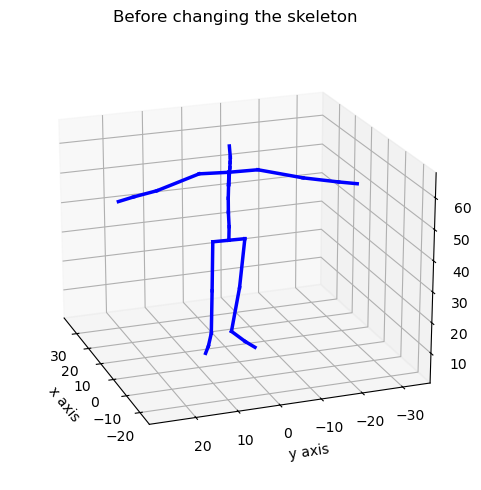

In [62]:
filepath = bvh_folder / 'bvh_test1.bvh'
bvh = pybvh.read_bvh_file(filepath)

print("some nodes's offset from the original skeleton:")
for i in range(4):
    print(f"{bvh.nodes[i].name}'s offset: {bvh.nodes[i].offset}")


fig, ax = pybvh.plot.plot_frame(bvh, bvh.get_spatial_coord(frame_num=5))
ax.set_title('Before changing the skeleton')
plt.show()

nodes offset after scaling:
Hips's offset: [0. 0. 0.]
Spine's offset: [ 0.     0.    44.528]
Spine1's offset: [ 0.    -7.732 43.852]
Spine2's offset: [ 0.    -3.881 44.359]


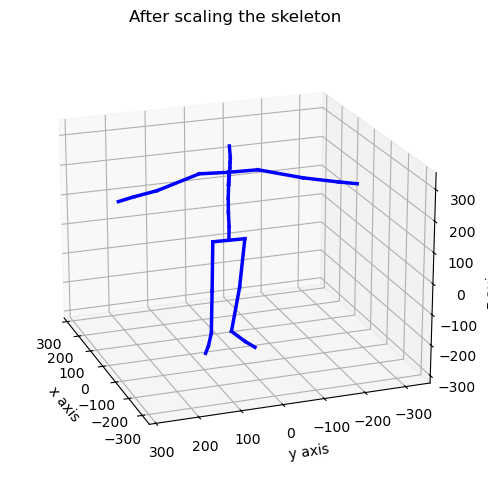

In [64]:
scale = 10
scaled_skeleton = bvh.scale_skeleton(scale)

print("nodes offset after scaling:")
for i in range(4):
    print(f"{scaled_skeleton.nodes[i].name}'s offset: {scaled_skeleton.nodes[i].offset}")


fig, ax = pybvh.plot.plot_frame(scaled_skeleton, scaled_skeleton.get_spatial_coord(frame_num=5))
ax.set_title('After scaling the skeleton')
plt.show()